In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/iba-ml2-final-project/train.csv
/kaggle/input/iba-ml2-final-project/test.csv
/kaggle/input/iba-ml2-final-project/sample_submisstion.csv


## Importing necessary libraries

In [3]:
import numpy as np                       # linear algebra
import pandas as pd                      # data processing
import matplotlib.pyplot as plt         # Visualization
import seaborn as sns                   # Visualization

import missingno                        # Let's see if we have missings
import calendar                         #All we have is dates, we gonna definitely need this


#scikit-learn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [4]:
from fbprophet import Prophet
print("Done")

Done


In [5]:
train_data = pd.read_csv("/kaggle/input/iba-ml2-final-project/train.csv")

In [6]:
train_data.head()

,Date,Consumption
0,2006-01-01,1069.184
1,2006-01-02,1380.521
2,2006-01-03,1442.533
3,2006-01-04,1457.217
4,2006-01-05,1477.131


In [7]:
train_data.describe()

,Consumption
count,3287.000000
mean,1323.847855
std,164.563581
min,842.395000
25%,1205.200500
50%,1353.055000
75%,1445.183500
max,1709.568000


<AxesSubplot:>

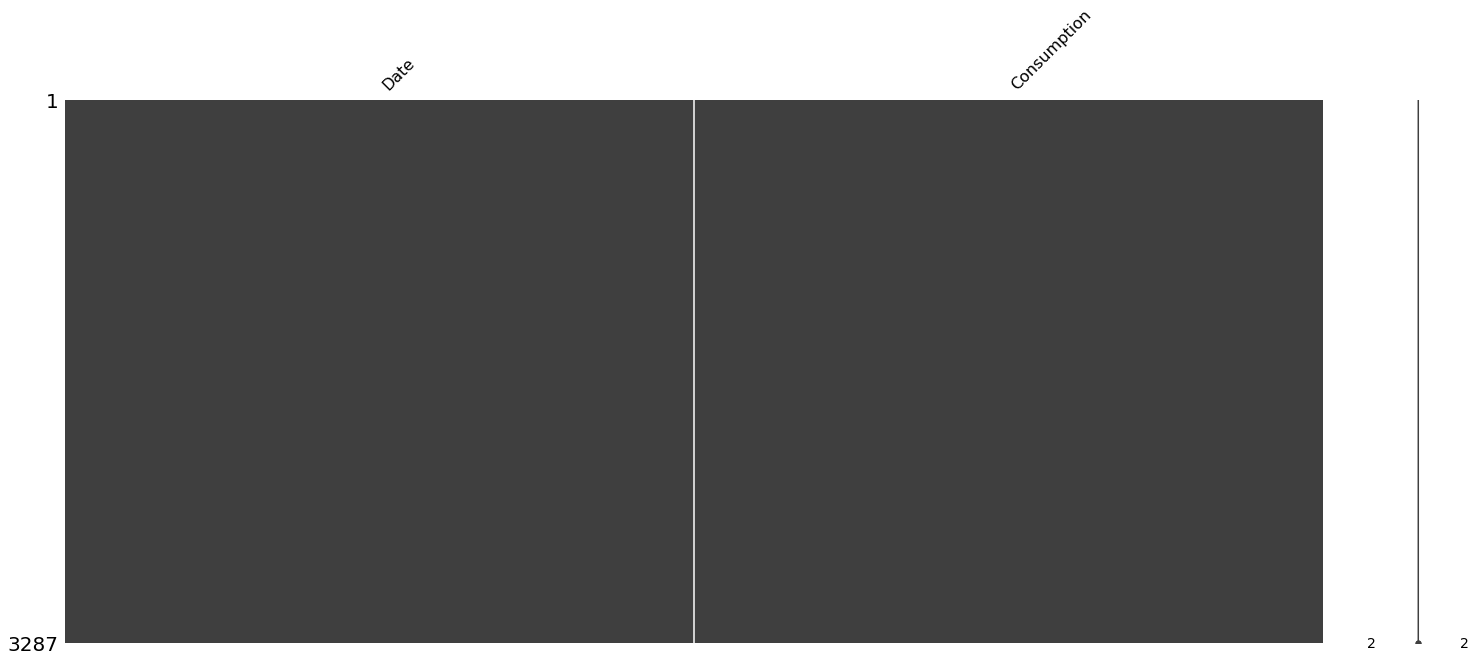

In [8]:
missingno.matrix(train_data)

In [9]:
train_data["Date"] = train_data["Date"].astype('datetime64[ns]')


In [10]:
#train_data = train_data.set_index('Date')


In [11]:
train_data.head()

,Date,Consumption
0,2006-01-01,1069.184
1,2006-01-02,1380.521
2,2006-01-03,1442.533
3,2006-01-04,1457.217
4,2006-01-05,1477.131


In [12]:
train_data.index

RangeIndex(start=0, stop=3287, step=1)

# Exploratory  Data Analysis

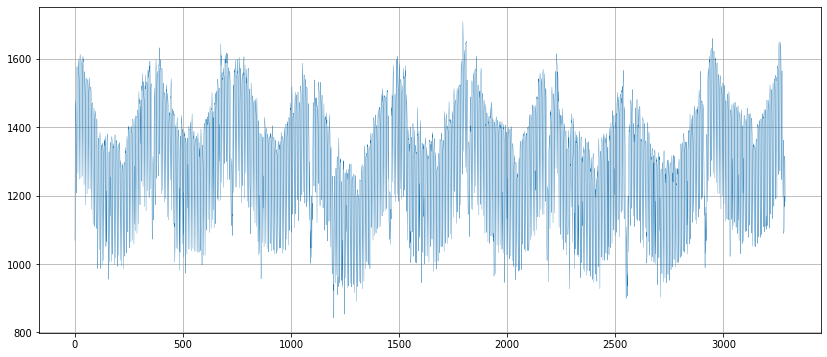

In [13]:
train_data["Consumption"].sort_values(ascending=False).head(10)

plt.figure(figsize=(14,6))
train_data["Consumption"].plot(linewidth=0.3)
plt.grid()
plt.show()

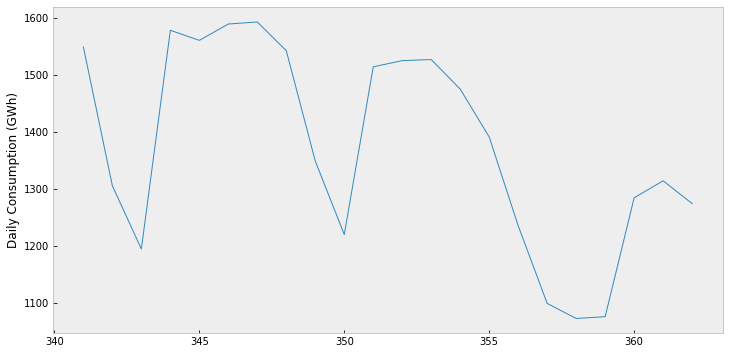

In [387]:
plt.figure(figsize=(12,6))
ax = train_data.query("Date < '2006-12-30' & Date > '2006-12-07' ")['Consumption'].plot(linewidth=1)
ax.set_ylabel('Daily Consumption (GWh)');
plt.grid()

Seems we have some weekly seasonality according to the graph above

## Trend through months

Let's check the trend through months to get sense of seasonality if it is present.

In [15]:
monthly_grouped = train_data.groupby(train_data['Date'].dt.month).mean()
monthly_grouped['Date'] = monthly_grouped.index
monthly_grouped['Date'] = monthly_grouped['Date'].apply(lambda x: calendar.month_name[x])

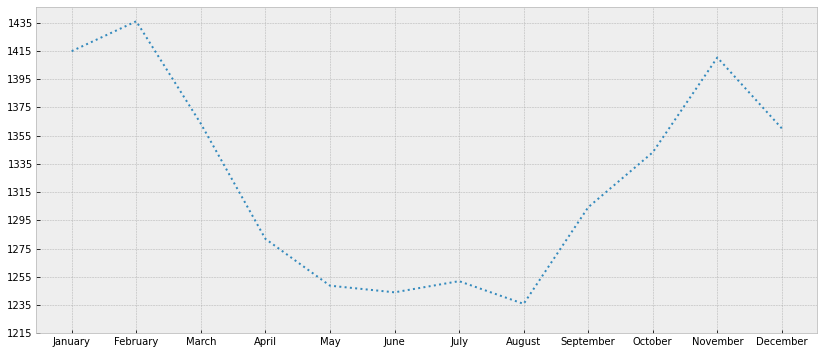

In [16]:
plt.style.use('bmh')
plt.figure(figsize=(14,6))
plt.plot(monthly_grouped["Date"], monthly_grouped["Consumption"], ":")
plt.yticks(np.arange(1215,1450,20))

plt.show()

*As it can be seen from observed from graph, in summer the general trend is having low consumption compared to winter.*

In [17]:
percentage = round((monthly_grouped["Consumption"].max()-monthly_grouped["Consumption"].min())/monthly_grouped["Consumption"].max()*100,3)
print(f"There is a gap of {percentage} % between maximum and minimum valeus of monthly averages through years.")

There is a gap of 13.938 % between maximum and minimum valeus of monthly averages through years.


### Trend through years

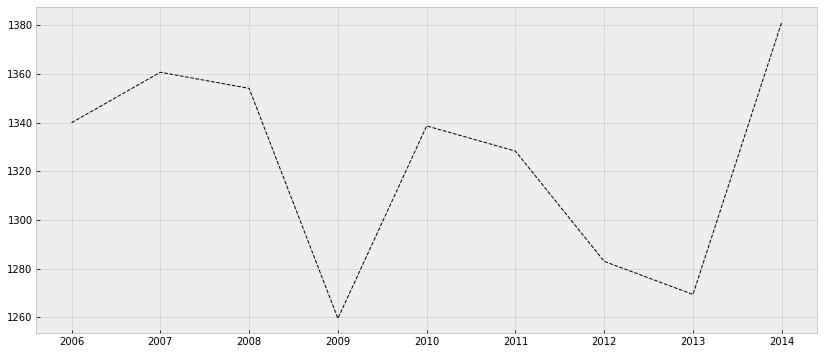

In [18]:
plt.figure(figsize=(14,6))
plt.plot(train_data.groupby(train_data['Date'].dt.year).mean(), linewidth=1,color ='black', linestyle = '--')
plt.show()

# Predictions

### With Recurrent Neural Network structure

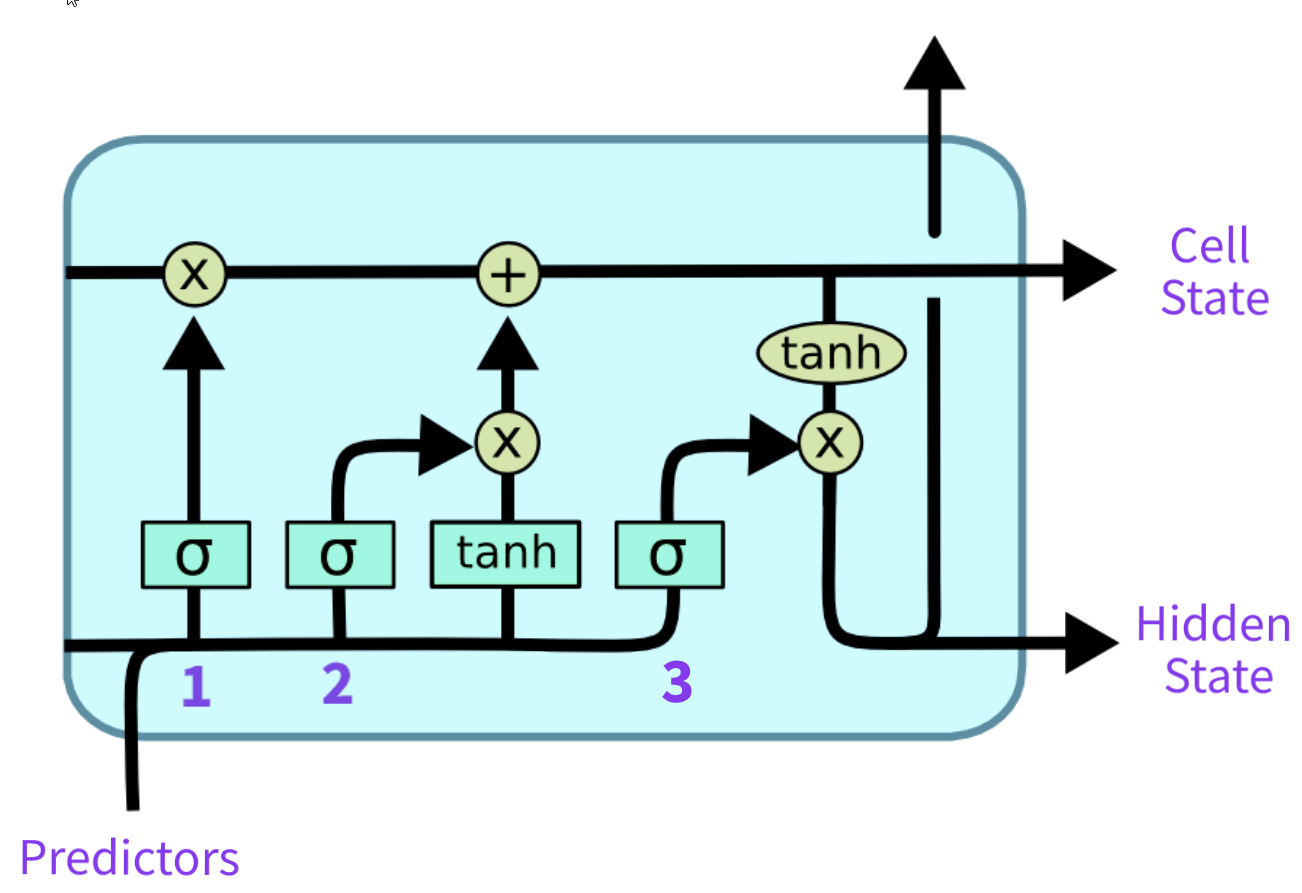

In [137]:
import tensorflow as tf 
from keras.layers import Dense, SimpleRNN, Dropout, LSTM
from keras.models import Sequential

In [201]:
train_data2 = train_data.copy()
train_data2.set_index(train_data['Date'])
train_data2.head()

train_data2.drop("Date", axis=1, inplace = True)

In [202]:
scaler = MinMaxScaler()
train_data2['Consumption']=scaler.fit_transform(train_data2['Consumption'].values.reshape(-1,1))

In [203]:
len(train_data2)

3287

In [205]:
seq_len = 21
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 6189 days are going to be used in test
    X_test = X_train[3000:]             
    y_test = y_train[3000:]
    
    #2 first 110000 days are going to be used in training
    X_train = X_train[:3000]           
    y_train = y_train[:3000]
    
    #3 convert to numpy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)

    print(len(X_train))
    #4 reshape data to input into RNN models
    X_train = np.reshape(X_train, (3000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test]

In [206]:
X_train, y_train, X_test, y_test = load_data(train_data2, seq_len)


3000


In [208]:
print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_test.shape = ', X_test.shape)
print('y_test.shape = ',y_test.shape)

X_train.shape =  (3000, 21, 1)
y_train.shape =  (3000,)
X_test.shape =  (266, 21, 1)
y_test.shape =  (266,)


Dropout level denotes an option which switches nodes in the network on or off. This is to prevent overfitting. The nodes are less prone to dig themselves deeper and deeper into a particular configuration of connected nodes.

In [209]:
rnn_model = Sequential()

rnn_model.add(SimpleRNN(40, activation = 'tanh', return_sequences = True, input_shape=(X_train.shape[1],1)))
rnn_model.add(Dropout(0.1))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model.add(Dropout(0.15))

rnn_model.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model.add(Dropout(0.2))


rnn_model.add(Dense(1))

rnn_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_29 (SimpleRNN)    (None, 21, 40)            1680      
_________________________________________________________________
dropout_32 (Dropout)         (None, 21, 40)            0         
_________________________________________________________________
simple_rnn_30 (SimpleRNN)    (None, 21, 40)            3240      
_________________________________________________________________
dropout_33 (Dropout)         (None, 21, 40)            0         
_________________________________________________________________
simple_rnn_31 (SimpleRNN)    (None, 21, 40)            3240      
_________________________________________________________________
dropout_34 (Dropout)         (None, 21, 40)            0         
_________________________________________________________________
simple_rnn_32 (SimpleRNN)    (None, 21, 40)           

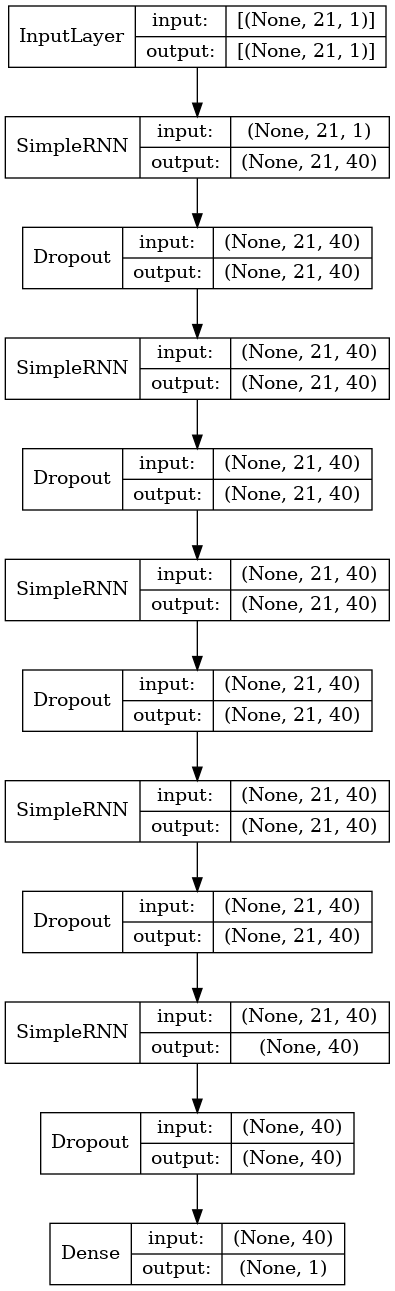

In [210]:
from keras.utils.vis_utils import plot_model

plot_model(rnn_model, show_shapes=True, show_layer_names=False)

In [211]:
rnn_model.compile(optimizer="adam",loss="MSE")
rnn_model.fit(X_train, y_train, epochs=30, batch_size=100)

Epoch 1/25
30/30 [==============================] - 6s 61ms/step - loss: 0.4940
Epoch 2/25
30/30 [==============================] - 2s 59ms/step - loss: 0.3374
Epoch 3/25
30/30 [==============================] - 2s 61ms/step - loss: 0.2783
Epoch 4/25
30/30 [==============================] - 2s 59ms/step - loss: 0.2131
Epoch 5/25
30/30 [==============================] - 2s 60ms/step - loss: 0.1774
Epoch 6/25
30/30 [==============================] - 2s 60ms/step - loss: 0.1481
Epoch 7/25
30/30 [==============================] - 2s 60ms/step - loss: 0.1258
Epoch 8/25
30/30 [==============================] - 2s 59ms/step - loss: 0.1202
Epoch 9/25
30/30 [==============================] - 2s 61ms/step - loss: 0.1003
Epoch 10/25
30/30 [==============================] - 2s 59ms/step - loss: 0.0905
Epoch 11/25
30/30 [==============================] - 2s 66ms/step - loss: 0.0777
Epoch 12/25
30/30 [==============================] - 2s 73ms/step - loss: 0.0722
Epoch 13/25
30/30 [==================

In [212]:
rnn_predictions = rnn_model.predict(X_test)


In [213]:
test = pd.DataFrame(y_test,columns=['Actual'])
pred = pd.DataFrame(rnn_predictions,columns=['Predict'])
results = pd.concat([test,pred],axis=1)
results.head(7)

,Actual,Predict
0,0.741202,0.792594
1,0.706176,0.744908
2,0.443742,0.465467
3,0.330636,0.329596
4,0.733455,0.701499
5,0.763529,0.805460
6,0.742858,0.822132


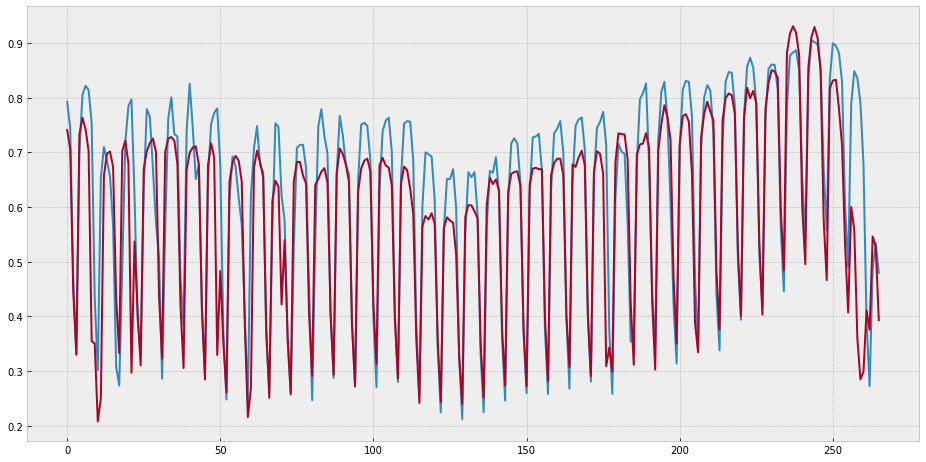

In [214]:
plt.figure(figsize=(16,8))
plt.plot(rnn_predictions)
plt.plot(y_test)

In [215]:
invtest = scaler.inverse_transform(y_test.reshape((-1,1)))
invpred = scaler.inverse_transform(rnn_predictions.reshape((-1,1)))

rnn_score = r2_score(invtest,invpred)
mse = (mean_squared_error(invtest,invpred))**(0.5)
print("R2 Score of RNN model = ",rnn_score)
print("MSE Score of RNN model = ",mse)

R2 Score of RNN model =  0.6763524134847343
MSE Score of RNN model =  87.8720881898515


In [216]:
#R2 Score of RNN model =  0.7713039179082114
#MSE Score of RNN model =  73.84953771370581

## With LSTM

In [217]:
train_data_lstm = train_data.copy()
train_data_lstm.set_index(train_data['Date'])
train_data_lstm.head()

train_data_lstm.drop("Date", axis=1, inplace = True)

In [218]:
scaler = MinMaxScaler()
train_data_lstm['Consumption']=scaler.fit_transform(train_data_lstm['Consumption'].values.reshape(-1,1))

In [219]:
X_train_lstm, y_train_lstm, X_test_lstm, y_test_lstm = load_data(train_data_lstm, 100)


3000


In [220]:
print('X_train.shape = ',X_train_lstm.shape)
print('y_train.shape = ', y_train_lstm.shape)
print('X_test.shape = ', X_test_lstm.shape)
print('y_test.shape = ',y_test_lstm.shape)

X_train.shape =  (3000, 100, 1)
y_train.shape =  (3000,)
X_test.shape =  (187, 100, 1)
y_test.shape =  (187,)


In [221]:
lstm_model = Sequential()

lstm_model.add(LSTM(50,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(50,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(50,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 21, 50)            10400     
_________________________________________________________________
dropout_37 (Dropout)         (None, 21, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 21, 50)            20200     
_________________________________________________________________
dropout_38 (Dropout)         (None, 21, 50)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_39 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

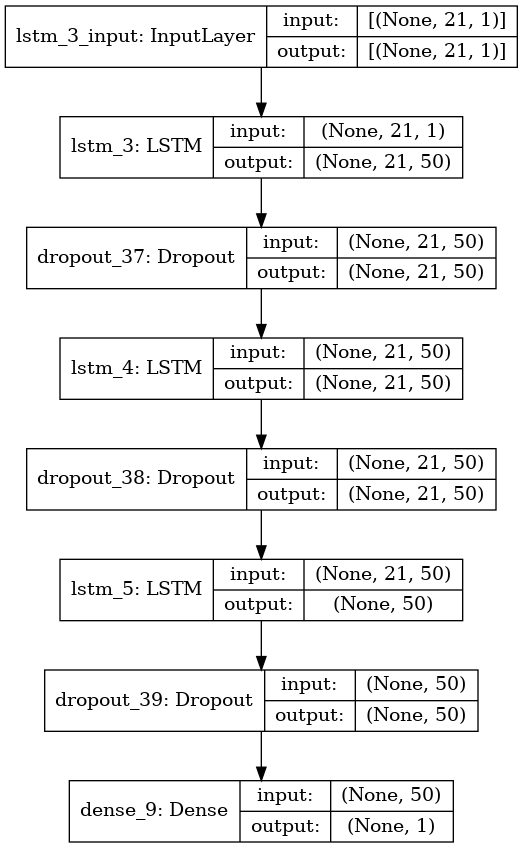

In [222]:
plot_model(lstm_model, show_shapes=True, show_layer_names=True)

In [223]:
lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=20, batch_size=1000)

Epoch 1/20
3/3 [==============================] - 9s 1s/step - loss: 0.3121
Epoch 2/20
3/3 [==============================] - 3s 1s/step - loss: 0.1144
Epoch 3/20
3/3 [==============================] - 3s 1s/step - loss: 0.0578
Epoch 4/20
3/3 [==============================] - 3s 1s/step - loss: 0.0522
Epoch 5/20
3/3 [==============================] - 3s 1s/step - loss: 0.0386
Epoch 6/20
3/3 [==============================] - 3s 1s/step - loss: 0.0476
Epoch 7/20
3/3 [==============================] - 3s 1s/step - loss: 0.0388
Epoch 8/20
3/3 [==============================] - 3s 1s/step - loss: 0.0330
Epoch 9/20
3/3 [==============================] - 3s 1s/step - loss: 0.0366
Epoch 10/20
3/3 [==============================] - 3s 1s/step - loss: 0.0360
Epoch 11/20
3/3 [==============================] - 4s 1s/step - loss: 0.0321
Epoch 12/20
3/3 [==============================] - 3s 1s/step - loss: 0.0342
Epoch 13/20
3/3 [==============================] - 3s 1s/step - loss: 0.0339
Epoch 14

In [43]:
lstm_predictions = lstm_model.predict(X_test_lstm)

lstm_score = r2_score(lstm_predictions,y_test_lstm)
print("R^2 Score of LSTM model = ",lstm_score)

R^2 Score of LSTM model =  -12.358910282938533


In [463]:
def create_features(df, target_variable):
   
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if target_variable:
        y = df[target_variable]
        return X, y
    return X

In [464]:
def timeseries_evaluation_metrics_func(y_true, y_pred):
   
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')

In [46]:
from sklearn import metrics
timeseries_evaluation_metrics_func(lstm_predictions,y_test_lstm)

MSE is : 0.028982572737667158
MAE is : 0.15409471663155114
RMSE is : 0.17024268776563403
R2 is : -12.358910282938533



### With Prophet

In [47]:
preddata = train_data[:3280].copy()
preddata.rename(columns={'Date':'ds','Consumption':'y'},inplace=True)

preddata.tail(3)

,ds,y
3277,2014-12-22,1363.140
3278,2014-12-23,1326.533
3279,2014-12-24,1154.524


In [48]:
m = Prophet(daily_seasonality=True, weekly_seasonality = True, yearly_seasonality = True,changepoint_prior_scale= 0.7,seasonality_prior_scale=10)
m.fit(preddata)
future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)

Initial log joint probability = -43.0635
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9033.04    0.00360114       1854.77      0.9238      0.9238      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9082.09    0.00165324       547.786      0.5451      0.5451      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9088.55   0.000654848       220.967      0.1466           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        9097.7    0.00749336       1492.13           1           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       9107.61     0.0127889       988.231           1           1      573   
    Iter      log prob        ||dx||      ||grad||       alpha  

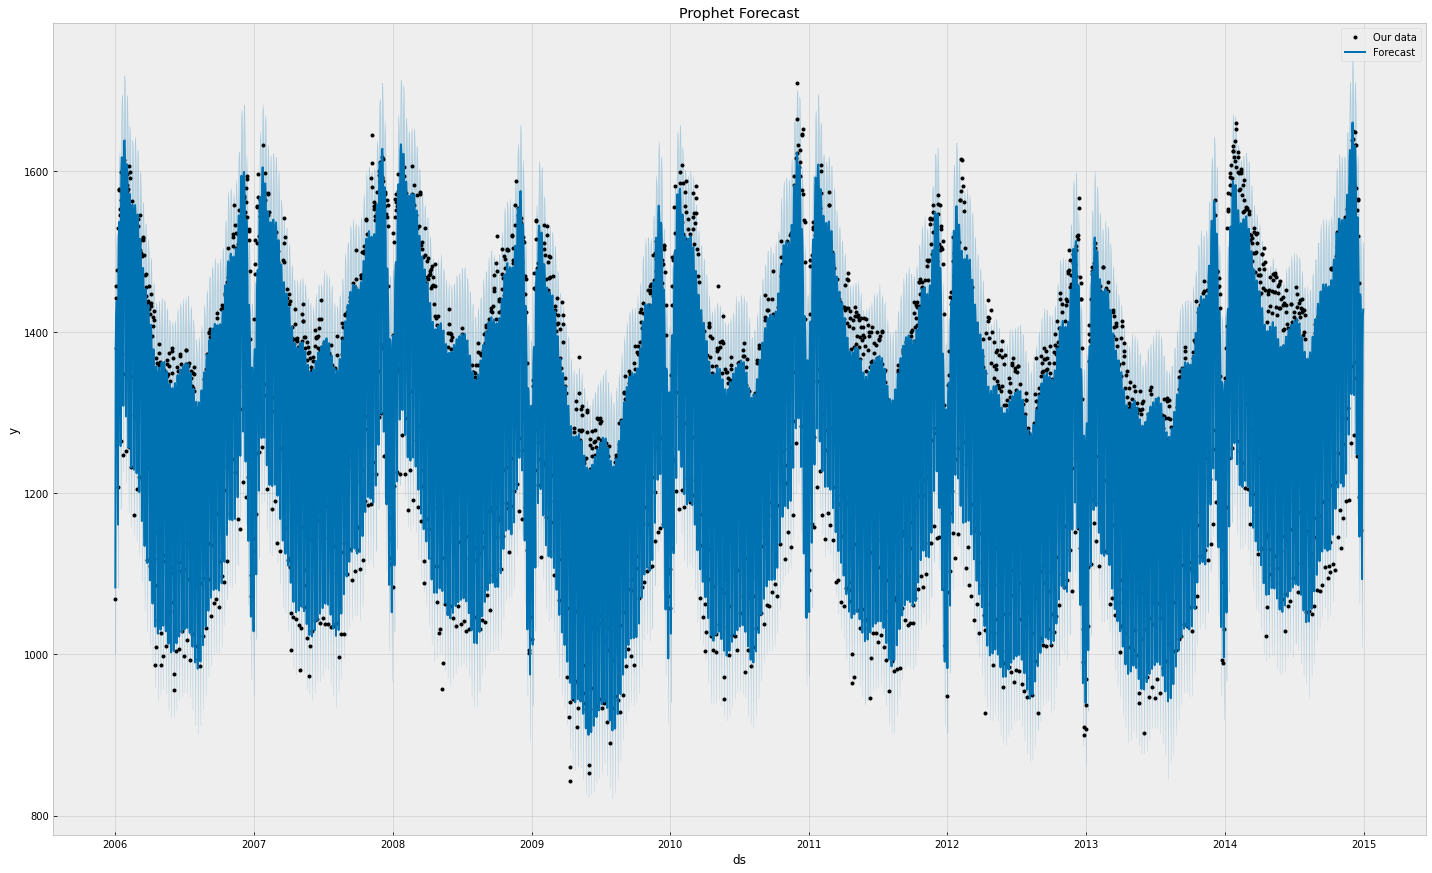

In [49]:
m.plot(forecast,figsize=(20,12))
plt.legend(labels=['Our data','Forecast'])
plt.title('Prophet Forecast')
plt.show()

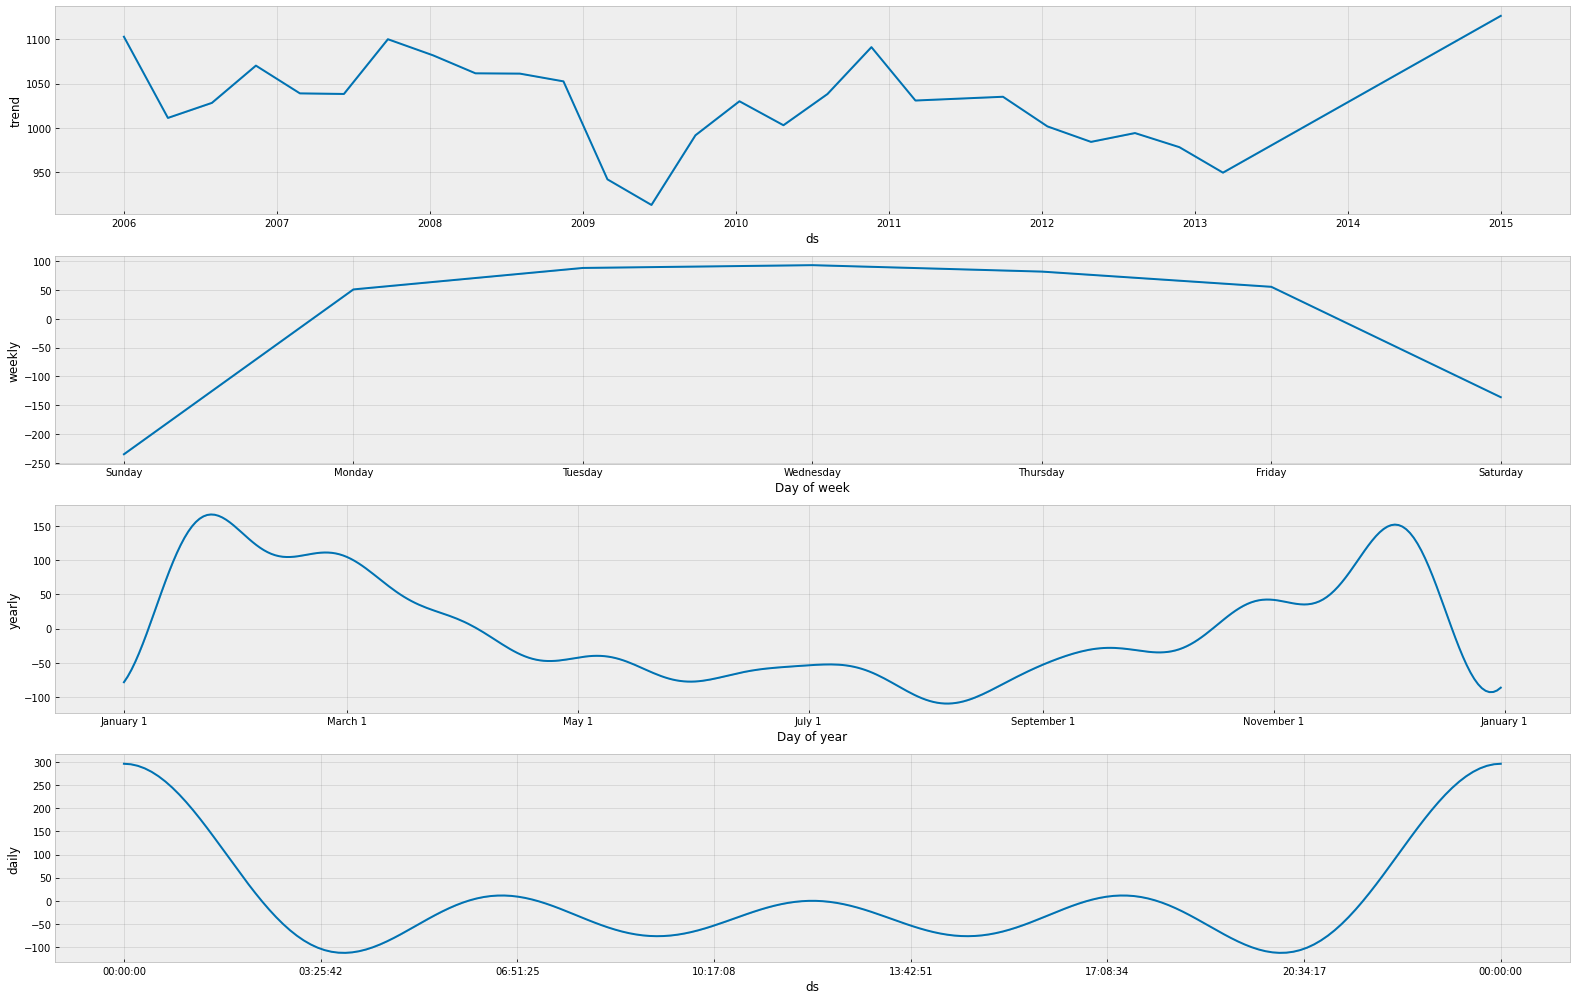

In [50]:
fig3 = m.plot_components(forecast, figsize = (22,14))


### Validation

In [51]:
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation

In [52]:
predicted = forecast[3280:][["yhat","ds"]]

In [53]:
forecast[3280:]["yhat"]

3280    1423.276978
3281    1390.811457
3282    1194.758189
3283    1093.447276
3284    1379.924052
3285    1419.206581
3286    1428.016266
Name: yhat, dtype: float64

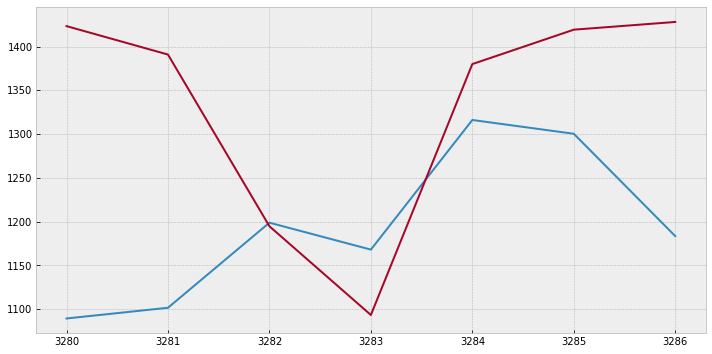

In [54]:
plt.figure(figsize=(12,6))
plt.plot(train_data[3280:]["Consumption"])
plt.plot(predicted["yhat"])

In [55]:
mean_squared_error(train_data[3280:]["Consumption"], predicted["yhat"], squared=False)

199.4986975382942

### Hyperparamter tuning

In [56]:
cutoffs = pd.to_datetime(['2013-08-15', '2014-02-15'])


In [57]:

import itertools
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5, 1],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0, 20.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

#Use cross validation to evaluate all parameters
#for params in all_params:
#    m = Prophet(**params).fit(preddata)  # Fit model with given params
#    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='7 days', parallel="processes")
#    df_p = performance_metrics(df_cv, rolling_window=1)
#    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
#tuning_results = pd.DataFrame(all_params)
#tuning_results['rmse'] = rmses
#print(tuning_results)

In [58]:
#print(tuning_results.sort_values(by = 'rmse'))

# Xgboost comes into the play

In [59]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 887 kB/s            
Note: you may need to restart the kernel to use updated packages.


In [60]:
from sklearn import metrics

from pmdarima.model_selection import train_test_split as time_train_test_split

from xgboost import XGBRegressor
from xgboost import plot_importance

In [61]:
train_data_xgb = train_data.copy()
train_data_xgb = train_data_xgb.set_index('Date')
train_data_xgb.head()

,Consumption
Date,
2006-01-01,1069.184
2006-01-02,1380.521
2006-01-03,1442.533
2006-01-04,1457.217
2006-01-05,1477.131


In [62]:
X = train_data_xgb['Consumption']

# Test Size = 20%
trainxgb, testxgb = time_train_test_split(X, test_size=int(len(train_data_xgb)*0.2))

trainxgb = pd.DataFrame(trainxgb)
testxgb = pd.DataFrame(testxgb)

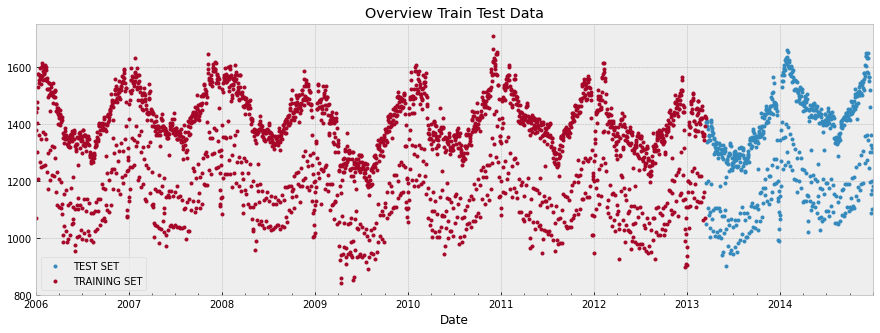

In [63]:
Overview_Train_Test_Data = testxgb \
    .rename(columns={'Consumption': 'TEST SET'}) \
    .join(trainxgb.rename(columns={'Consumption': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='Overview Train Test Data', style='.')

In [64]:
trainxgb_copy = trainxgb.copy()
testxgb_copy = testxgb.copy()

trainX, trainY = create_features(trainxgb_copy, target_variable='Consumption')
testX, testY = create_features(testxgb_copy, target_variable='Consumption')
trainX.head(3)

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,
2006-01-01,0,6,1,1,2006,1,1,52
2006-01-02,0,0,1,1,2006,2,2,1
2006-01-03,0,1,1,1,2006,3,3,1


In [65]:
xgb = XGBRegressor(objective= 'reg:linear', colsample_bytree = 0.7, max_depth=6, n_estimators=2000,learning_rate = 0.48) #learning_rate = 0.25
xgb

xgb.fit(trainX, trainY,
        eval_set=[(trainX, trainY), (testX, testY)],
        early_stopping_rounds=100,
        verbose=False) # Change verbose to True if you want to see it train

[17:32:06] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.48, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=2000, n_jobs=4,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

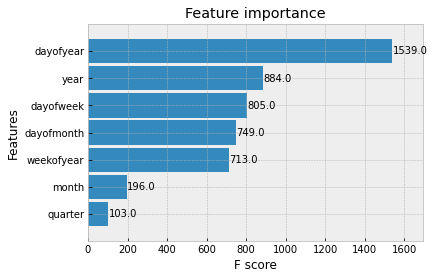

In [66]:
feature_importance = plot_importance(xgb, height=0.9)
feature_importance

In [67]:
predicted_results = xgb.predict(testX)

In [68]:
timeseries_evaluation_metrics_func(testY, predicted_results)


MSE is : 7344.689970271561
MAE is : 68.78562960634277
RMSE is : 85.7011666797574
R2 is : 0.732266308452581



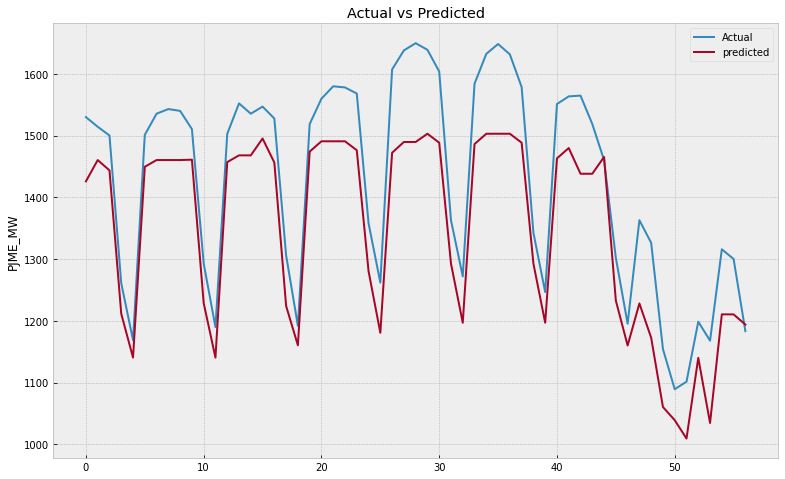

In [69]:
plt.figure(figsize=(13,8))
plt.plot(list(testY)[600:700])
plt.plot(list(predicted_results)[600:700])
plt.title("Actual vs Predicted")
plt.ylabel("PJME_MW")
plt.legend(('Actual','predicted'))
plt.show()

### Predictions seems to be low especially in the last years, let's try ***hyperparameter tuning***

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

In [71]:
xgb_grid = XGBRegressor(objective= 'reg:linear')
parameters = {
    'n_estimators': [700, 1000, 1400],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15,20,25]}
    #'reg_alpha': [1.1, 1.2, 1.3],
    #'reg_lambda': [1.1, 1.2, 1.3],
    #'subsample': [0.7, 0.8, 0.9]

In [72]:
fit_params={"early_stopping_rounds":50, 
            "eval_metric" : "rmse", 
            "eval_set" : [[testX, testY]]}

In [73]:
cv = 3

#grid_search = GridSearchCV(
#    estimator=xgb_grid,
#    param_grid=parameters,
#    scoring = 'neg_mean_squared_error',
#    n_jobs = -1,
#    cv = TimeSeriesSplit(n_splits=cv).get_n_splits([trainX, trainY]),
#    verbose=1)

#xgb_grid_model = grid_search.fit(trainX, trainY, **fit_params)

In [74]:
print('Best Parameter:')
#print(xgb_grid_model.best_params_) 
print()
print('------------------------------------------------------------------')
print()
#print(xgb_grid_model.best_estimator_)

Best Parameter:

------------------------------------------------------------------



# Final Predictions

## Fb Prophet

In [75]:
predictiondata = train_data.copy()
predictiondata.rename(columns={'Date':'ds','Consumption':'y'},inplace=True)

predictiondata.tail(3)

,ds,y
3284,2014-12-29,1316.093
3285,2014-12-30,1300.367
3286,2014-12-31,1183.510


In [76]:
m = Prophet(daily_seasonality=False, weekly_seasonality = True, yearly_seasonality = True,changepoint_prior_scale= 0.4,seasonality_prior_scale=10)
m.fit(predictiondata)
future = m.make_future_dataframe(periods=7)
forecast = m.predict(future)

Initial log joint probability = -40.111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       9029.36     0.0492643       3406.26           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       9073.19    0.00168054       185.989      0.8122      0.8122      233   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       9084.05    0.00679164       125.777           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       9092.37    0.00329649        101.54           1           1      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       9097.38     0.0125289       554.787           1           1      575   
    Iter      log prob        ||dx||      ||grad||       alpha   

In [77]:
data = forecast['yhat'].tail(7).tolist()

In [78]:
final = pd.DataFrame(index=range(1090),columns=['Date','Consumption_day_1','Consumption_day_2','Consumption_day_3','Consumption_day_4','Consumption_day_5','Consumption_day_6','Consumption_day_7'])


In [79]:
for i in range(0,7):
        final['Consumption_day_'+'{}'.format(i+1)] = final['Consumption_day_'+'{}'.format(i+1)].map({np.NaN: data[i]})
        


In [80]:
date = pd.date_range('1/1/2015', periods=1090, freq='D')
final = final.assign(Date=date)
final['Date'] = final['Date'].dt.strftime('%-#m/%-#d/%Y')

In [81]:
def create_submissiondf(predictionlist):
    final = pd.DataFrame(index=range(1090),columns=['Date','Consumption_day_1','Consumption_day_2','Consumption_day_3','Consumption_day_4','Consumption_day_5','Consumption_day_6','Consumption_day_7'])
    for i in range(0,7):
        final['Consumption_day_'+'{}'.format(i+1)] = final['Consumption_day_'+'{}'.format(i+1)].map({np.NaN: predictionlist[i,0]})
        date = pd.date_range('1/1/2015', periods=1090, freq='D')
    final = final.assign(Date=date)
    final['Date'] = final['Date'].dt.strftime('%-#m/%-#d/%Y')
    return final


In [82]:
final.head()

,Date,Consumption_day_1,Consumption_day_2,Consumption_day_3,Consumption_day_4,Consumption_day_5,Consumption_day_6,Consumption_day_7
0,1/1/2015,1409.282804,1390.763482,1209.031476,1121.193296,1420.036695,1471.011153,1490.310349
1,1/2/2015,1409.282804,1390.763482,1209.031476,1121.193296,1420.036695,1471.011153,1490.310349
2,1/3/2015,1409.282804,1390.763482,1209.031476,1121.193296,1420.036695,1471.011153,1490.310349
3,1/4/2015,1409.282804,1390.763482,1209.031476,1121.193296,1420.036695,1471.011153,1490.310349
4,1/5/2015,1409.282804,1390.763482,1209.031476,1121.193296,1420.036695,1471.011153,1490.310349


# SARIMAX

In [84]:
import statsmodels.api as sm

In [85]:
train_data4 = train_data.copy()
train_data4 = train_data4.set_index('Date')
train_data4.tail()

,Consumption
Date,
2014-12-27,1198.834
2014-12-28,1168.079
2014-12-29,1316.093
2014-12-30,1300.367
2014-12-31,1183.510


In [86]:
model=sm.tsa.statespace.SARIMAX(train_data4['Consumption'],order=(3, 2, 1),seasonal_order=(1,1,1,7))
results=model.fit()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.79639D+00    |proj g|=  1.35289D-01

At iterate    5    f=  5.67220D+00    |proj g|=  2.30136D-02

At iterate   10    f=  5.64566D+00    |proj g|=  1.35210D-02

At iterate   15    f=  5.52946D+00    |proj g|=  1.76924D-01

At iterate   20    f=  5.46987D+00    |proj g|=  8.68778D-03

At iterate   25    f=  5.46981D+00    |proj g|=  4.60918D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     45      1     0     0   

In [87]:
train_data4.tail()

,Consumption
Date,
2014-12-27,1198.834
2014-12-28,1168.079
2014-12-29,1316.093
2014-12-30,1300.367
2014-12-31,1183.510


<AxesSubplot:xlabel='Date'>

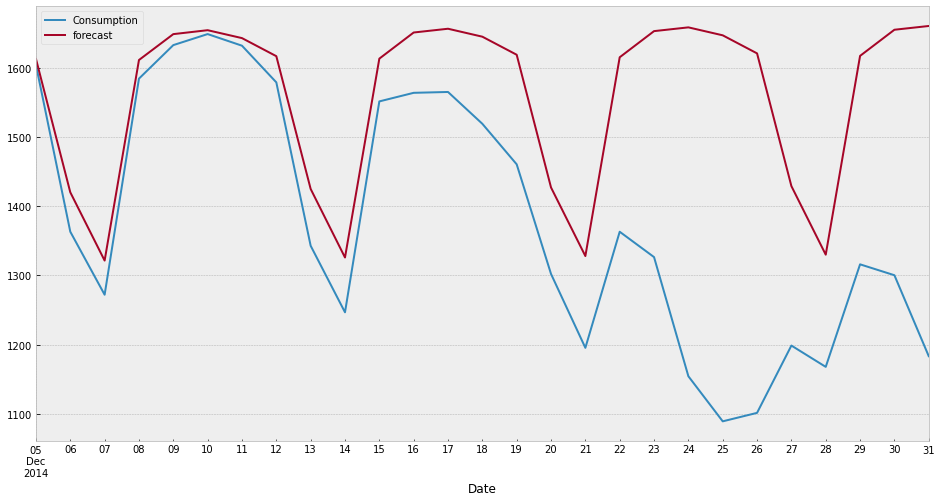

In [88]:
train_data4['forecast']=results.predict(start=3260,end=3287,dynamic=True)
train_data4[['Consumption','forecast']][3260:].plot(figsize=(16,8))

In [89]:
timeseries_evaluation_metrics_func(train_data4['forecast'][3260:],train_data4['Consumption'][3260:])

MSE is : 60772.467587045765
MAE is : 179.12890242124374
RMSE is : 246.5207244574901
R2 is : -3.0150188760768994



## Recurrant Neural Networks

In [353]:
train_data3 = train_data.copy()
train_data3 = train_data3.set_index('Date')
train_data3.tail()

,Consumption
Date,
2014-12-27,1198.834
2014-12-28,1168.079
2014-12-29,1316.093
2014-12-30,1300.367
2014-12-31,1183.510


In [354]:
scaler3  = MinMaxScaler()
train_data3['Consumption']=scaler3.fit_transform(train_data3['Consumption'].values.reshape(-1,1))
train_data3.head()

,Consumption
Date,
2006-01-01,0.261527
2006-01-02,0.620552
2006-01-03,0.692063
2006-01-04,0.708996
2006-01-05,0.731960


In [355]:
rnn_model2 = Sequential()

rnn_model2.add(SimpleRNN(40, activation = 'tanh', return_sequences = True, input_shape=(X_train.shape[1],1)))
rnn_model2.add(Dropout(0.1))

rnn_model2.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model2.add(Dropout(0.15))

rnn_model2.add(SimpleRNN(40,activation="tanh",return_sequences=True))
rnn_model2.add(Dropout(0.15))


rnn_model2.add(SimpleRNN(40,activation="tanh",return_sequences=False))
rnn_model2.add(Dropout(0.2))

rnn_model2.add(Dense(1))


In [356]:
seq_len = 30
def load_data_pred(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
  
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    print(len(X_train))

    X_train = np.reshape(X_train, (3257, seq_len, 1))
    
    
    return [X_train, y_train]

In [357]:
predictiondata = load_data_pred(train_data3,seq_len)

3257


In [358]:
rnn_model2.compile(optimizer="adam",loss="MSE")
rnn_model2.fit(X_train, y_train, epochs=50, batch_size=200)

Epoch 1/50
15/15 [==============================] - 4s 54ms/step - loss: 0.3415
Epoch 2/50
15/15 [==============================] - 1s 53ms/step - loss: 0.2284
Epoch 3/50
15/15 [==============================] - 1s 55ms/step - loss: 0.1780
Epoch 4/50
15/15 [==============================] - 1s 54ms/step - loss: 0.1324
Epoch 5/50
15/15 [==============================] - 1s 60ms/step - loss: 0.1225
Epoch 6/50
15/15 [==============================] - 1s 52ms/step - loss: 0.1049
Epoch 7/50
15/15 [==============================] - 1s 53ms/step - loss: 0.0867
Epoch 8/50
15/15 [==============================] - 1s 53ms/step - loss: 0.0778
Epoch 9/50
15/15 [==============================] - 1s 52ms/step - loss: 0.0713
Epoch 10/50
15/15 [==============================] - 1s 53ms/step - loss: 0.0622
Epoch 11/50
15/15 [==============================] - 1s 53ms/step - loss: 0.0559
Epoch 12/50
15/15 [==============================] - 1s 56ms/step - loss: 0.0552
Epoch 13/50
15/15 [==================

In [359]:
timestep=7

In [360]:
def insert_end(Xin,new_input):
    #print ('Before: \n', Xin , new_input )
    for i in range(timestep-1):
        Xin[:,i,:] = Xin[:,i+1,:]
    Xin[:,timestep-1,:] = new_input
    #print ('After :\n', Xin)
    return Xin

In [361]:
# this section for unknown future
#we are getting next 30 steps
from datetime import timedelta
future=7
forcast = []
Xin = X_test[-1:,:,:]
time=[]
for i in range(future):
    out = rnn_model2.predict(Xin, batch_size=1)    
    forcast.append(out[0,0]) 
    print(forcast)
    Xin = insert_end(Xin,out[0,0]) 
    time.append(pd.to_datetime(train_data3.index[-1])+timedelta(days=i+1))

[0.44242546]
[0.44242546, 0.4431336]
[0.44242546, 0.4431336, 0.44413903]
[0.44242546, 0.4431336, 0.44413903, 0.4446376]
[0.44242546, 0.4431336, 0.44413903, 0.4446376, 0.44435543]
[0.44242546, 0.4431336, 0.44413903, 0.4446376, 0.44435543, 0.44417912]
[0.44242546, 0.4431336, 0.44413903, 0.4446376, 0.44435543, 0.44417912, 0.44419295]


In [362]:
forcasted_output=np.asanyarray(forcast)  

In [363]:
forcasted_output_shaped=forcasted_output.reshape(-1,1) 
forcasted_output_inversed = scaler3.inverse_transform(forcasted_output_shaped) 

In [364]:
forcasted_output_inversed

array([[1226.0543],
       [1226.6685],
       [1227.5404],
       [1227.9727],
       [1227.728 ],
       [1227.5751],
       [1227.5872]], dtype=float32)

In [350]:
forcasted_outputdf = pd.DataFrame(forcasted_output_inversed)
date = pd.DataFrame(time)
df_result = pd.concat([date,forcasted_outputdf],axis=1)
df_result.columns = "Date","Forecasted"

In [334]:
df_result

,Date,Forecasted
0,2015-01-01,1190.151733
1,2015-01-02,1193.581665
2,2015-01-03,1200.665527
3,2015-01-04,1202.781494
4,2015-01-05,1203.399048
5,2015-01-06,1204.184082
6,2015-01-07,1202.869141


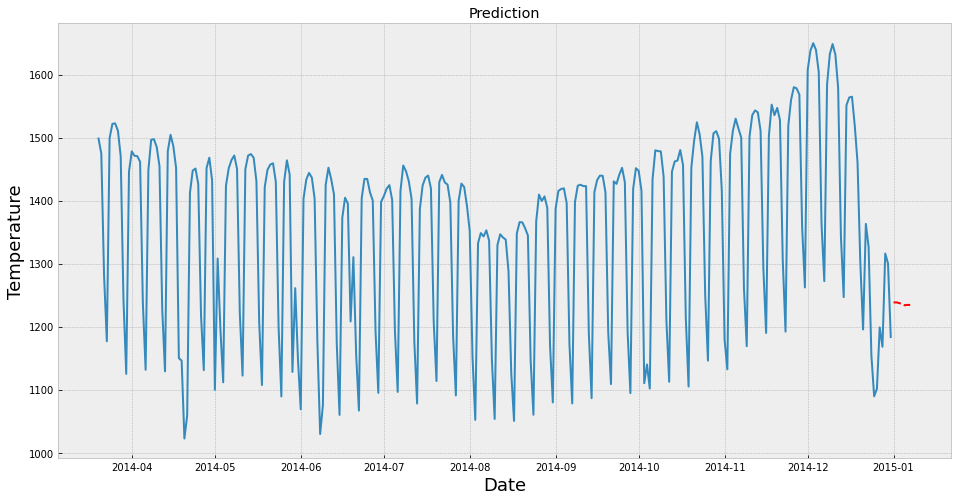

In [352]:
plt.figure(figsize=(16,8))
plt.title('Prediction')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Temperature' ,fontsize=18)
plt.plot(train_data4['Consumption'][3000:])
plt.plot(df_result.set_index('Date')[['Forecasted']],"r--")

plt.show()

In [301]:
rnn_submission = create_submissiondf(forcasted_output_inversed)
rnn_submission.head()

,Date,Consumption_day_1,Consumption_day_2,Consumption_day_3,Consumption_day_4,Consumption_day_5,Consumption_day_6,Consumption_day_7
0,1/1/2015,1293.725098,1290.079834,1288.217896,1284.907227,1281.530518,1278.708374,1277.458496
1,1/2/2015,1293.725098,1290.079834,1288.217896,1284.907227,1281.530518,1278.708374,1277.458496
2,1/3/2015,1293.725098,1290.079834,1288.217896,1284.907227,1281.530518,1278.708374,1277.458496
3,1/4/2015,1293.725098,1290.079834,1288.217896,1284.907227,1281.530518,1278.708374,1277.458496
4,1/5/2015,1293.725098,1290.079834,1288.217896,1284.907227,1281.530518,1278.708374,1277.458496


## Prediction with SARIMAX

In [453]:
train_data5 = train_data.copy()
train_data5 = train_data5.set_index('Date')
train_data5.tail()

,Consumption
Date,
2014-12-27,1198.834
2014-12-28,1168.079
2014-12-29,1316.093
2014-12-30,1300.367
2014-12-31,1183.510


In [454]:
sarimax_final = pd.DataFrame(index=range(7),columns=['Date','Consumption','forecast'])
date = pd.date_range('1/1/2015', periods=7, freq='D')
sarimax_final = sarimax_final.assign(Date=date)
sarimax_final.index = sarimax_final['Date']
sarimax_final.drop('Date', axis=1,inplace = True)
train_data5 = train_data5.append(sarimax_final)
train_data5.tail(10)

,Consumption,forecast
Date,,
2014-12-29,1316.093,NaN
2014-12-30,1300.367,NaN
2014-12-31,1183.510,NaN
2015-01-01,NaN,NaN
2015-01-02,NaN,NaN
2015-01-03,NaN,NaN
2015-01-04,NaN,NaN
2015-01-05,NaN,NaN
2015-01-06,NaN,NaN


In [455]:
#scaler4  = sklearn.preprocessing.MinMaxScaler()
#train_data5['Consumption']=scaler4.fit_transform(train_data5['Consumption'].values.reshape(-1,1))

In [456]:
model_sarimax=sm.tsa.statespace.SARIMAX(train_data5['Consumption'],order=(1, 1, 2),seasonal_order=(1,1,1,50),freq="D")
results=model_sarimax.fit()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:539: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.37071D+00    |proj g|=  2.29981D-01


 This problem is unconstrained.



At iterate    5    f=  6.23877D+00    |proj g|=  1.31653D-02

At iterate   10    f=  6.22921D+00    |proj g|=  2.69978D-03

At iterate   15    f=  6.21544D+00    |proj g|=  4.28197D-02

At iterate   20    f=  6.17941D+00    |proj g|=  3.77840D-03

At iterate   25    f=  6.14866D+00    |proj g|=  2.36034D-02

At iterate   30    f=  6.14687D+00    |proj g|=  1.60696D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     45      1     0     0   7.437D-06   6.147D+00
  F =   6.1468631160727556     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


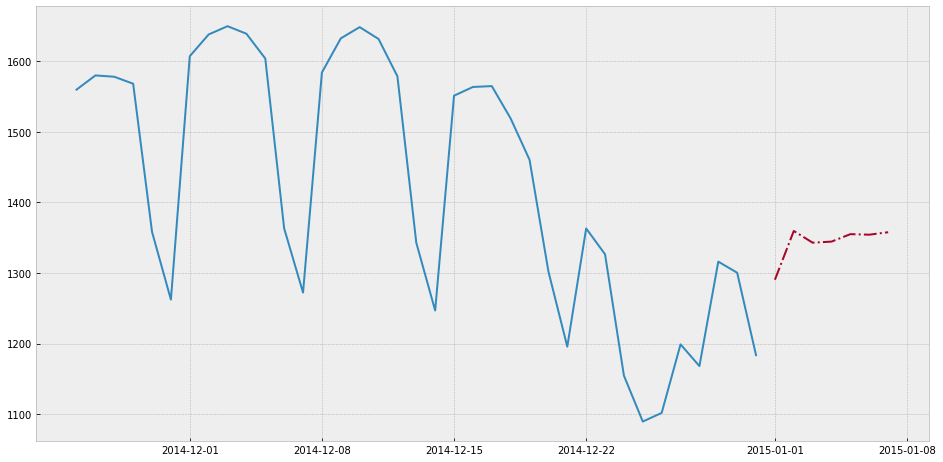

In [457]:
plt.figure(figsize=(16,8))

train_data5['forecast']=results.predict(start=3287,end=3294,dynamic=False)
plt.plot(train_data5[['Consumption']][3250:])
plt.plot(train_data5[['forecast']][3286:], '-.')
plt.show()

In [458]:
sarimax_prediction_list = train_data5[['forecast']][3287:].values

In [459]:
sarimax_prediction = create_submissiondf(sarimax_prediction_list)
sarimax_prediction.head()

,Date,Consumption_day_1,Consumption_day_2,Consumption_day_3,Consumption_day_4,Consumption_day_5,Consumption_day_6,Consumption_day_7
0,1/1/2015,1290.443012,1359.57544,1342.944555,1344.499913,1355.060846,1354.291251,1357.80276
1,1/2/2015,1290.443012,1359.57544,1342.944555,1344.499913,1355.060846,1354.291251,1357.80276
2,1/3/2015,1290.443012,1359.57544,1342.944555,1344.499913,1355.060846,1354.291251,1357.80276
3,1/4/2015,1290.443012,1359.57544,1342.944555,1344.499913,1355.060846,1354.291251,1357.80276
4,1/5/2015,1290.443012,1359.57544,1342.944555,1344.499913,1355.060846,1354.291251,1357.80276


# Prediction with XGBoost

In [423]:
train_data6 = train_data.copy()
train_data6 = train_data6.set_index('Date')
train_data6.tail(8)

,Consumption
Date,
2014-12-24,1154.524
2014-12-25,1089.457
2014-12-26,1101.683
2014-12-27,1198.834
2014-12-28,1168.079
2014-12-29,1316.093
2014-12-30,1300.367
2014-12-31,1183.510


In [397]:
trainX, trainY = create_features(train_data6, target_variable='Consumption')
trainY.tail(3)

Date
2014-12-29    1316.093
2014-12-30    1300.367
2014-12-31    1183.510
Name: Consumption, dtype: float64

In [398]:
xgb2 = XGBRegressor(objective= 'reg:linear', colsample_bytree = 0.5, max_depth=15, n_estimators=2000,learning_rate = 0.48) #learning_rate = 0.25
xgb2

xgb2.fit(trainX, trainY,
        
        verbose=False) # Change verbose to True if you want to see it train

[18:49:03] WARNING: ../src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.48, max_delta_step=0,
             max_depth=15, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=2000, n_jobs=4,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [399]:
x_final = pd.DataFrame(index=range(7),columns=['Date'])
date = pd.date_range('1/1/2015', periods=7, freq='D')
x_final = x_final.assign(Date=date)
#x_final = x_final.assign(Consumption=[1000,1000,1000,1000,1000,1000,1000])
x_final.index = x_final['Date']
x_final.drop('Date', axis=1,inplace = True)
x_final


""
Date
2015-01-01
2015-01-02
2015-01-03
2015-01-04
2015-01-05
2015-01-06
2015-01-07


In [400]:

x_final['hour'] = x_final.index.hour
x_final['dayofweek'] = x_final.index.dayofweek
x_final['quarter'] = x_final.index.quarter
x_final['month'] = x_final.index.month
x_final['year'] = x_final.index.year
x_final['dayofyear'] = x_final.index.dayofyear
x_final['dayofmonth'] = x_final.index.day
x_final['weekofyear'] = x_final.index.weekofyear

In [401]:
x_final

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,
2015-01-01,0,3,1,1,2015,1,1,1
2015-01-02,0,4,1,1,2015,2,2,1
2015-01-03,0,5,1,1,2015,3,3,1
2015-01-04,0,6,1,1,2015,4,4,1
2015-01-05,0,0,1,1,2015,5,5,2
2015-01-06,0,1,1,1,2015,6,6,2
2015-01-07,0,2,1,1,2015,7,7,2


In [402]:
testX = testX.append(x_final)

In [403]:
predicted_results2 = xgb2.predict(testX)

In [133]:
testX.tail()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,
2015-01-03,0,5,1,1,2015,3,3,1
2015-01-04,0,6,1,1,2015,4,4,1
2015-01-05,0,0,1,1,2015,5,5,2
2015-01-06,0,1,1,1,2015,6,6,2
2015-01-07,0,2,1,1,2015,7,7,2


In [405]:
x_final2 = pd.DataFrame(index=range(7),columns=['Date'])
date = pd.date_range('1/1/2015', periods=7, freq='D')
x_final2 = x_final2.assign(Date=date)
x_final2.index = x_final2['Date']
x_final2.drop('Date', axis=1,inplace = True)
x_final2

""
Date
2015-01-01
2015-01-02
2015-01-03
2015-01-04
2015-01-05
2015-01-06
2015-01-07


In [406]:
trainX, trainY = create_features(trainxgb_copy, target_variable='Consumption')
testX, testY = create_features(testxgb_copy, target_variable='Consumption')
trainX.head(3)

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
Date,,,,,,,,
2006-01-01,0,6,1,1,2006,1,1,52
2006-01-02,0,0,1,1,2006,2,2,1
2006-01-03,0,1,1,1,2006,3,3,1


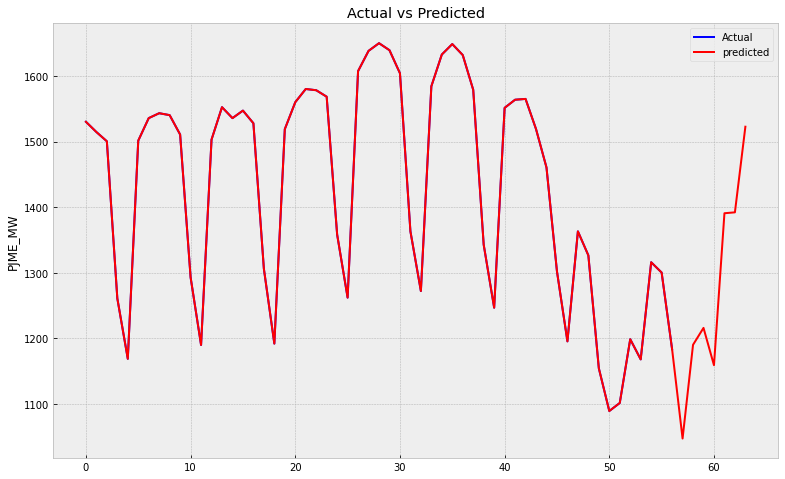

In [407]:
plt.figure(figsize=(13,8))
plt.plot(list(testY)[600:750], color='b')
plt.plot(list(predicted_results2)[600:750], color='red')
plt.title("Actual vs Predicted")
plt.ylabel("PJME_MW")
plt.legend(('Actual','predicted'))
plt.show()

In [ ]:
xgblist = predicted_results2[:7].tolist()

In [ ]:
def create_submissiondf2(predictionlist):
    final = pd.DataFrame(index=range(1090),columns=['Date','Consumption_day_1','Consumption_day_2','Consumption_day_3','Consumption_day_4','Consumption_day_5','Consumption_day_6','Consumption_day_7'])
    for i in range(0,7):
        final['Consumption_day_'+'{}'.format(i+1)] = final['Consumption_day_'+'{}'.format(i+1)].map({np.NaN: predictionlist[i]})
        date = pd.date_range('1/1/2015', periods=1090, freq='D')
    final = final.assign(Date=date)
    final['Date'] = final['Date'].dt.strftime('%-#m/%-#d/%Y')
    return final

In [ ]:
xgb_prediction = create_submissiondf2(xgblist)
